In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtree import DecisionTree

plt.ioff()

## Part 1: Tennis example

The tennis data comprises of 4 features (Outlook, Temperature, Humidity, Wind) and a label (PlayTennis).

In [34]:
# reading training data
data = pd.read_csv('tennis.csv', header=0)
features = data.columns[:-1]
label = data.columns[-1]
data

,Outlook,Temperature,Humidity,Wind,PlayTennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


First, training and testing decision on the same instances as a sanity check.

In [35]:
# creating empty decision tree, demonstrating information gain calculations
d = DecisionTree()
maxig, name, split = d.max_info_gain(data, features, label)
# From observation, the best attribute is Outlook
print(maxig, name)

0.246749819774 Outlook


In [36]:
# training the tree on the loaded data
d.train(data, label)
# after training, the root node should have Outlook attribute, and the child node for Overcase should have a label
print('Root:', d.root)
print('Children:', d.root.children)

Root: Outlook node
Children: {'Overcast': Yes label, 'Rain': Wind node, 'Sunny': Humidity node}


In [37]:
# checking if trained tree perfectly predicts training instances
(d.predict(data) == data[label]).all()

True

Then, splitting the training data in a 4/10 test/train split.

Accuracy: 0.75


<IPython.core.display.Javascript object>


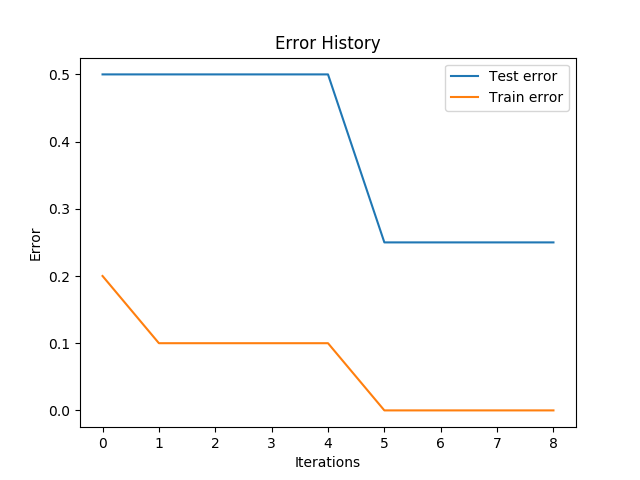

In [38]:
train = data.head(10)  # training set
test = data.tail(4)    # validation set
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': train})  # training and obtaining error history
print('Accuracy:', (d.predict(test) == test[label]).sum() / len(test))
# plotting
plt.plot(hist['test'], label='Test error')
plt.plot(hist['train'], label='Train error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()

## Part 2: Exoplanet Survey Data

The survey is a collection of more than 9000 astronomical observations and their status as confirmed, false positive, or candidate exoplanets. We only consider *confirmed* or *false positive* labels. Additionally, the 14 features are continuous and have large distributions. So as a preprocessing step, the values are scaled logarithmically and discretized into `nbins` categories each.

<IPython.core.display.Javascript object>


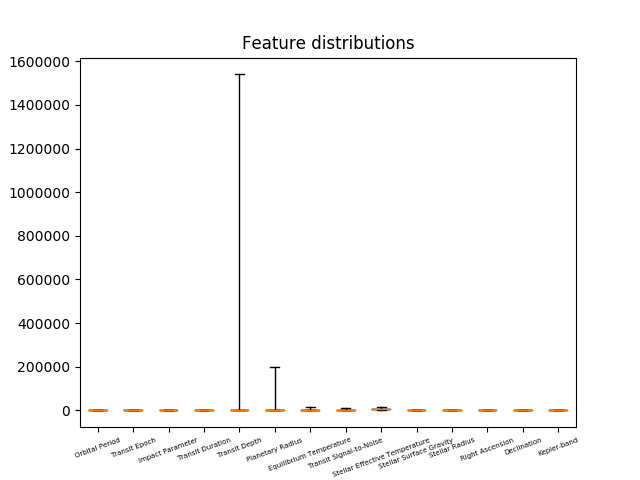

,Disposition,Orbital Period,Transit Epoch,Impact Parameter,Transit Duration,Transit Depth,Planetary Radius,Equilibrium Temperature,Transit Signal-to-Noise,Stellar Effective Temperature,Stellar Surface Gravity,Stellar Radius,Right Ascension,Declination,Kepler-band
15,FALSE POSITIVE,19.40,172.48,0.80,12.22,8920.0,7.18,523.0,214.7,5043.0,4.59,0.68,289.26,47.64,15.49
6717,FALSE POSITIVE,30.96,263.32,0.77,4.41,342.0,2.34,686.0,13.1,6525.0,4.38,1.16,294.34,39.29,14.75
828,FALSE POSITIVE,9.09,139.08,0.98,6.26,780.0,5.35,1104.0,72.7,6739.0,4.33,1.28,297.12,47.74,14.41
4357,FALSE POSITIVE,0.87,132.08,0.95,1.46,197.0,1.87,1998.0,23.8,5761.0,4.33,1.05,293.35,40.06,14.77
3996,FALSE POSITIVE,2.08,131.83,0.77,7.50,894000.0,345.70,2719.0,1585.2,8344.0,4.04,2.12,299.02,41.82,16.45


In [8]:
raw_data = pd.read_csv('exoplanets.csv', header=0)
raw_data = raw_data.sample(frac=1)  # shuffling data
features = raw_data.columns[1:] # feature column names
label = raw_data.columns[0]     # label column name
# plotting
plt.boxplot(raw_data[features].values, labels=features, whis='range')
plt.xticks(rotation=20, fontsize=5)
plt.title('Feature distributions')
plt.show()
raw_data.head(5)

<IPython.core.display.Javascript object>


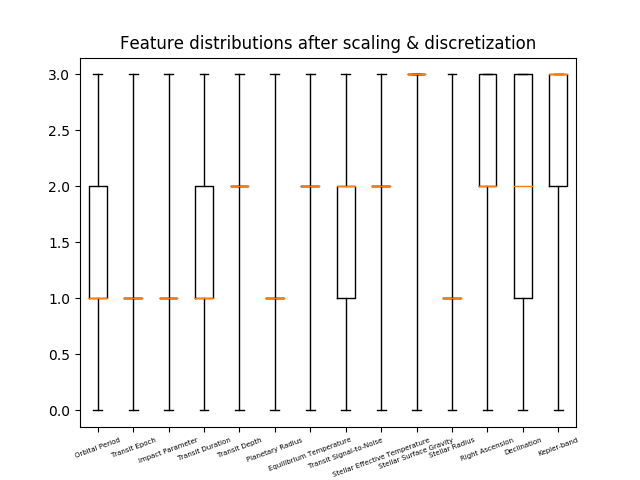

In [9]:
# preprocessing raw_data by logarithmic scaling and discretization
nbins = 3
# scaling features
data = np.log(raw_data[features] + 1)
data[label] = raw_data[label]
# discretizing features
for feature in features:
    _, bins = np.histogram(data[feature], nbins)
    data[feature] = np.digitize(data[feature], bins, right=True)
# splitting into train/test sets
ntrain = 500
ntest = 100
nval = 100
train = data.iloc[:ntrain]
test = data.tail(ntest)
# visualizing change in feature distributions
plt.boxplot(data[features].values, labels=features, whis='range')
plt.xticks(rotation=20, fontsize=5)
plt.title('Feature distributions after scaling & discretization')
plt.show()

In [17]:
# Calculating the distribution of labels in the data set
label_freq = data.groupby(label)[label].count()
label_freq /= label_freq.sum()
print(label_freq)

Disposition
CONFIRMED         0.32692
FALSE POSITIVE    0.67308
Name: Disposition, dtype: float64


Therefore, assuming that an instance is `CONFIRMED` is the event $C$, `FALSE POSITIVE` is the event $F$, a `CONFIRMED` prediction is $CP$, and a `FALSE POSITIVE` prediction is $FP$.

$$P(C) = 0.33$$
$$P(F) = 0.67$$

For a naive majority based classifier, $P(CP \mid C) = 0$ and $P(FP \mid F) = 1$. The error rate will be:

$$1 - P(CP \mid C) \cdot P(C) - P(FP \mid F) \cdot P(F) = 0.33$$

The classifier needs to perform better than this benchmark.

<IPython.core.display.Javascript object>


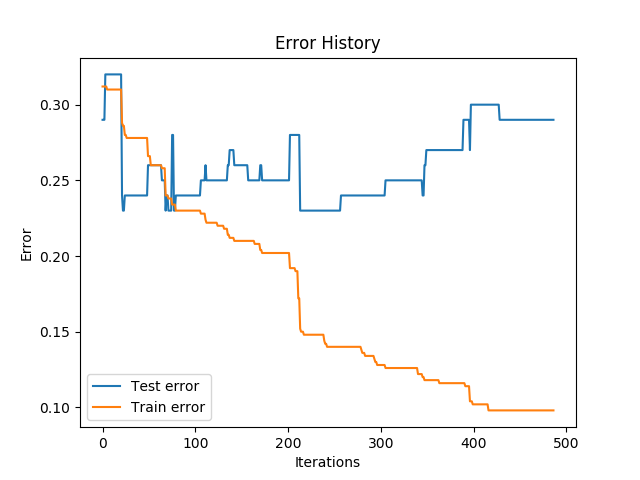

In [33]:
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': train})
# plotting
plt.figure()
plt.plot(hist['test'], label='Test error')
plt.plot(hist['train'], label='Train error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()

## Part 3: Pruning

<IPython.core.display.Javascript object>


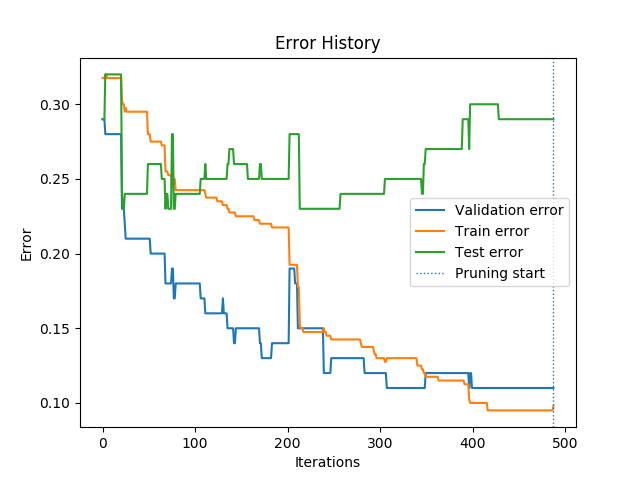

In [31]:
# split training into training/validation
train = train.sample(frac=1)
val = train.iloc[:nval]
subtrain = train.iloc[nval:]
# train on new split
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': subtrain, 'val': val})
# prune
prune_hist = d.prune(val, label, train, test)
# plotting
plt.figure()
plt.plot(hist['val'] + prune_hist[0], label='Validation error')
plt.plot(hist['train'] + prune_hist[1], label='Train error')
plt.plot(hist['test'] + prune_hist[2], label='Test error')
nsteps = len(hist['val'])  # number of steps before pruning
plt.axvline(x=nsteps-1, label='Pruning start', linestyle='dotted', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()